# <span style="color:LightSlateGray;">Data Science Project Assessment of Database Performance Degradation</span>
# <span style="color:LightSlateGray;">Part 2 &ndash; Assessing the Database Load</span>
_CAS ADS 2019/2020 University of Berne_<br/>
_Author: Marco Bassi_, September 20, 2019

## Introduction

In Part 1 of the project the data taken from the databases DBA_HIST_SYSSTAT performance view have been cleansed. This 2nd part is about assessing the database load, i.e. its goal is to compare the load on the integration database to the load of the production database. For this purpose a number of selected statistics is analysed, displayed by box plots, and compared using the one-tailed and two-sided Wilcoxon Rank Sum Test.

### Waiting Classes
All wait events are assigned a waiting class. A waiting class totals up all the waiting times a database session spends in one of its wait events.
The 4 main waiting classes are 
* Application Wait Time
* Cluster Wait Time
* Concurrency Wait Time
* User I/O Wait Time

### Database Load Statistics
The statistics below are 7 out of a few tens of statistics measuring database load. The sample is chosen such that a variety of aspects of database load will be covered by the analysis.
The statistics chosen are
* db block changes
* enqueue requests
* execute count
* global enqueue gets async
* global enqueue gets sync
* parse count (total)
* user calls

### Set the environment

In [1]:
library(data.table)
library(ggplot2)
library(reshape2)
library(broom)
library(stats)
setwd('../../data')
getwd()

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt



[1] "C:/Users/ue85374/data/CAS-ADS/Git.repos/CAS-Applied-Data-Science/Data-Science-Project/project.1/statistiken.2019-08-22T0000-bis-2019-08-28T1000/data"

### Load the workspace image from Part 1 with the cleansed data

In [2]:
load(file="../analysis/R.workspaces/cleansed-data.RData")
ls()

[1] "dtNulled"

In [3]:
setkeyv(dtNulled, c("snapHour", "STAT_NAME"))
str(dtNulled)

Classes 'data.table' and 'data.frame':	114751 obs. of  4 variables:
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME : chr  "ADG parselock X get attempts" "ADG parselock X get successes" "Batched IO (bound) vector count" "Batched IO (full) vector count" ...
 $ sumValue_I: num  0 0 0 0 0 0 0 0 0 0 ...
 $ sumValue_P: num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME"


### Choose the statistics to compaire the two databases loads:
* application wait time (in centiseconds)
* cluster wait time (in centiseconds)
* concurrency wait time (in centiseconds)
* user I/O wait time (in centiseconds)
* db block changes (number)
* enqueue requests (number)
* execute count (number)
* global enqueue gets async (number)
* global enqueue gets sync (number)
* parse count (total, number)
* user calls (number)

In [4]:
dtNulled.selectForLoad <- dtNulled[ STAT_NAME %in% list(
'db block changes', 'enqueue requests', 'execute count', 'global enqueue gets async', 'global enqueue gets sync', 
'parse count (total)', 'user calls', 'application wait time', 'cluster wait time', 'user I/O wait time', 'concurrency wait time'), ]

In [5]:
# Transform the data.table into long format for further analysis
dtNulled.selectForLoad.melt <- melt(dtNulled.selectForLoad, id=c("snapHour", "STAT_NAME"), measured=c("sumValue_I","sumValue_P"))
setkeyv(dtNulled.selectForLoad.melt, c("snapHour", "STAT_NAME", "variable")) 
str(dtNulled.selectForLoad.melt)

Classes 'data.table' and 'data.frame':	3718 obs. of  4 variables:
 $ snapHour : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME: chr  "application wait time" "application wait time" "cluster wait time" "cluster wait time" ...
 $ variable : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 2 1 2 1 2 1 2 1 2 ...
 $ value    : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME" "variable"


### Compute the statistic deltas between the subsequent snapshots
As the statistics are running sums, we will have to compute the deltas between subsequent snapshots, grouped by statistic name (_STAT_NAME_) and database (_variable_).

In [6]:
dtNulled.selectForLoad.melt.diff <- dtNulled.selectForLoad.melt[,
list(snapHour, "deltaValue" = rep(diff(value), length.out = length(snapHour))), by=list(STAT_NAME, variable)]
str(dtNulled.selectForLoad.melt.diff)

Classes 'data.table' and 'data.frame':	3718 obs. of  4 variables:
 $ STAT_NAME : chr  "application wait time" "application wait time" "application wait time" "application wait time" ...
 $ variable  : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 1 1 1 1 1 1 1 1 1 ...
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 01:00:00" ...
 $ deltaValue: num  69027 70267 175935 140390 28059 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
setkeyv(dtNulled.selectForLoad.melt.diff, c("snapHour", "STAT_NAME", "variable"))
tail(dtNulled.selectForLoad.melt.diff[ STAT_NAME=="application wait time", ], 2)

STAT_NAME,variable,snapHour,deltaValue
application wait time,sumValue_I,2019-08-29,69027
application wait time,sumValue_P,2019-08-29,50847


In [8]:
head(dtNulled.selectForLoad.melt.diff[ STAT_NAME=="application wait time", ], 2)

STAT_NAME,variable,snapHour,deltaValue
application wait time,sumValue_I,2019-08-22,69027
application wait time,sumValue_P,2019-08-22,50847


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">The tail values of the deltas are identical to the head values. This _recycling_ is a necessity, in order to have a vector of deltas with the same length than the source vector. But as a consequence, the duplicates are set to NA.</span>

In [9]:
dtNulled.selectForLoad.melt.diff[snapHour == as.POSIXct("2019-08-29 00:00:00", format="%Y-%m-%d %H:%M:%S"), deltaValue := NA]

#### Get a summary of the data

In [10]:
summarySystatByPlatform.diff <- dtNulled.selectForLoad.melt.diff[, glance(summary(deltaValue)), by=list(STAT_NAME, variable)]
setkeyv(summarySystatByPlatform.diff, c("STAT_NAME", "variable"))

# Compute the interquartile ranges; they will be needed later to exclude outliers
summarySystatByPlatform.diff[, IQR := q3 - q1]
summarySystatByPlatform.diff

STAT_NAME,variable,minimum,q1,median,mean,q3,maximum,na,IQR
application wait time,sumValue_I,6820,11569.75,16227.0,168779.16,71340.00,4015674,9,59770.25
application wait time,sumValue_P,7788,18907.50,25639.0,66438.15,50517.75,1868934,1,31610.25
cluster wait time,sumValue_I,91997,577644.00,903754.5,1101479.02,1353930.75,22815546,9,776286.75
cluster wait time,sumValue_P,39150,189797.25,273147.0,272672.98,365832.75,533247,1,176035.50
concurrency wait time,sumValue_I,8133,40932.25,58263.0,441893.76,95188.25,16163233,9,54256.00
concurrency wait time,sumValue_P,7480,81408.50,157326.5,165464.41,219881.50,492176,1,138473.00
db block changes,sumValue_I,14336971,38069356.00,52784612.0,60344663.74,61718408.75,1853743142,9,23649052.75
db block changes,sumValue_P,8794902,34457248.00,51516647.0,46731356.10,59315800.25,80386952,1,24858552.25
enqueue requests,sumValue_I,1180925,3170619.25,4281665.5,4676407.58,5070251.25,97621707,9,1899632.00
enqueue requests,sumValue_P,1479446,5750198.25,8317312.0,7825687.60,9993156.25,12814288,1,4242958.00


### Start by testing the waiting classes statistics, using the Wilcoxon Rank Sum Test

#### <span style="font-style: italic; color: DarkGreen; font-size:1em;">Null Hypothesis: The medians of the waiting classes total waiting times of the integration and production databases are equal.</span>
#### <span style="font-style: italic; color: DarkGreen; font-size:1em;">Alternative Hypothesis: The medians are not equal</span>

In [11]:
waitclasses <- dtNulled.selectForLoad.melt.diff[
  STAT_NAME %in% list('application wait time', 'cluster wait time','concurrency wait time','user I/O wait time'), ]

statNames <- unique(waitclasses[, STAT_NAME])

i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe = list()
for (sName in statNames) {
    w <- wilcox.test(deltaValue ~ variable, data=waitclasses, paired=F, na.action = na.omit, subset = waitclasses[, STAT_NAME == sName])
    wtListe[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest <- data.frame(statNames, pval, h1, method)
colnames(wilcoxTest) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest

statistik,p.value,alternative,method
application wait time,1.511179e-03,two.sided,Wilcoxon rank sum test with continuity correction
cluster wait time,3.792887e-38,two.sided,Wilcoxon rank sum test with continuity correction
concurrency wait time,4.289956e-13,two.sided,Wilcoxon rank sum test with continuity correction
user I/O wait time,5.923306e-25,two.sided,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;"> As the confidence level is set to 95%, and the p-value is less than 5%,
we will discard the null hypothesis in favour of the alternative.</span>

#### Repeat the test, but exclude outliers
Outliers are measured values outside the boxplot whiskers, i.e. values greater than Q3 + 1.5&ensp;IQR, or less than Q1 - 1.5&ensp;IQR, where Q1 and Q3 are the 25% resp. 75% quartiles.

In [12]:
dtNulled.sFL.melt.diff.ext <- merge(
   dtNulled.selectForLoad.melt.diff,
   summarySystatByPlatform.diff,
   by = c("STAT_NAME", "variable"), all=T, incomparables=NA)

# exclude outliers from data
dtNulled.sFL.melt.diff.nooutlier <- dtNulled.sFL.melt.diff.ext[ deltaValue <= q3 + 1.5 * IQR & deltaValue >= q1 - 1.5 * IQR, ]
str(dtNulled.sFL.melt.diff.nooutlier)

Classes 'data.table' and 'data.frame':	3455 obs. of  12 variables:
 $ STAT_NAME : chr  "application wait time" "application wait time" "application wait time" "application wait time" ...
 $ variable  : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 1 1 1 1 1 1 1 1 1 ...
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 01:00:00" ...
 $ deltaValue: num  69027 70267 140390 28059 15293 ...
 $ minimum   : num  6820 6820 6820 6820 6820 6820 6820 6820 6820 6820 ...
 $ q1        : num  11570 11570 11570 11570 11570 ...
 $ median    : num  16227 16227 16227 16227 16227 ...
 $ mean      : num  168779 168779 168779 168779 168779 ...
 $ q3        : num  71340 71340 71340 71340 71340 ...
 $ maximum   : num  4015674 4015674 4015674 4015674 4015674 ...
 $ na        : num  9 9 9 9 9 9 9 9 9 9 ...
 $ IQR       : num  59770 59770 59770 59770 59770 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "STAT_NAME" "variable"


In [13]:
waitclasses.no <- dtNulled.sFL.melt.diff.nooutlier[
  STAT_NAME %in% list('application wait time', 'cluster wait time','concurrency wait time','user I/O wait time'), ]

i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.no = list()
for (sName in statNames) {
    w <- wilcox.test(deltaValue ~ variable, data=waitclasses.no, paired=F, na.action = na.omit, subset = waitclasses.no[, STAT_NAME == sName])
    wtListe.no[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.no <- data.frame(statNames, pval, h1, method)
colnames(wilcoxTest.no) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.no

statistik,p.value,alternative,method
application wait time,2.393673e-07,two.sided,Wilcoxon rank sum test with continuity correction
cluster wait time,6.211580e-38,two.sided,Wilcoxon rank sum test with continuity correction
concurrency wait time,5.054422e-25,two.sided,Wilcoxon rank sum test with continuity correction
user I/O wait time,6.777930e-29,two.sided,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;"> This confirms our result with outliers included</span>

#### First conclusions
1. From the data summary in a previous cell we see, that the Cluster and User I/O waiting classes make by far the highest contribution to the overall waiting times.
2. The total of the user I/O related waiting times is much higher on the production database than on integration. This difference can be attributed to one statement with an execution plan heavy on user I/O, and backup activities of the production platform.
3. The cluster related waiting times are much higher on the integration than on the production database. 

In the following we will try to explain the higher cluster waiting times with higher load on the integration database.

### Test the database load statistics, using the Wilcoxon Rank Sum Test

In [14]:
## Load statistics for database load
statisticsForDBLoad <- dtNulled.sFL.melt.diff.ext[ STAT_NAME %in% list(
 "db block changes", 
 "enqueue requests", 
 "execute count", 
 "global enqueue gets async", 
 "global enqueue gets sync" , 
 "parse count (total)", 
 "user calls"), ]
 str(statisticsForDBLoad)

Classes 'data.table' and 'data.frame':	2366 obs. of  12 variables:
 $ STAT_NAME : chr  "db block changes" "db block changes" "db block changes" "db block changes" ...
 $ variable  : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 1 1 1 1 1 1 1 1 1 ...
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 01:00:00" ...
 $ deltaValue: num  20715753 15183567 44063554 35422981 19752353 ...
 $ minimum   : num  14336971 14336971 14336971 14336971 14336971 ...
 $ q1        : num  38069356 38069356 38069356 38069356 38069356 ...
 $ median    : num  52784612 52784612 52784612 52784612 52784612 ...
 $ mean      : num  60344664 60344664 60344664 60344664 60344664 ...
 $ q3        : num  61718409 61718409 61718409 61718409 61718409 ...
 $ maximum   : num  1.85e+09 1.85e+09 1.85e+09 1.85e+09 1.85e+09 ...
 $ na        : num  9 9 9 9 9 9 9 9 9 9 ...
 $ IQR       : num  23649053 23649053 23649053 23649053 23649053 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr

#### <span style="font-style: italic; color: DarkGreen; font-size:1em;">Null Hypothesis: The medians of the database load statistics are greater on integration than on production, or equal.</span>
#### <span style="font-style: italic; color: DarkGreen; font-size:1em;">Alternative Hypothesis: The medians are smaller on integration than on production.</span>
For this test we compute a one-tailed Wilcoxon Rank Sum Test.

In [15]:
statNames <- unique(statisticsForDBLoad[, STAT_NAME])

## Wilcox rank sum test DB load statistics, with outliers included
## H0: Q50(Inte) >= Q50(Prod), i.e. higher DB load on Inte
i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.forDBLoad = list()
for (sName in statNames) {
    w <- wilcox.test(deltaValue ~ variable, data=statisticsForDBLoad, paired=F, alternative = "less", 
      na.action = na.omit, subset = statisticsForDBLoad[, STAT_NAME == sName])
    wtListe.forDBLoad[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.forDBLoad <- data.frame(statNames, pval, h1, method)
colnames(wilcoxTest.forDBLoad) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.forDBLoad

statistik,p.value,alternative,method
db block changes,9.130831e-01,less,Wilcoxon rank sum test with continuity correction
enqueue requests,5.531384e-30,less,Wilcoxon rank sum test with continuity correction
execute count,1.764491e-12,less,Wilcoxon rank sum test with continuity correction
global enqueue gets async,4.487811e-51,less,Wilcoxon rank sum test with continuity correction
global enqueue gets sync,6.010289e-13,less,Wilcoxon rank sum test with continuity correction
parse count (total),3.136130e-12,less,Wilcoxon rank sum test with continuity correction
user calls,9.099170e-14,less,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">For all statistics but one &mdash; db block changes &mdash; the null hypothesis must be discarded in favour of the alternative hypothesis. The result is confirmed by executing the same test, but this time excluding outliers. This test is not shown here.</span>

#### For db block changes let's test the medians for equality:
* Null hypothesis: The medians of this statistic are equal on the integration and production databases
* Alternative hypothesis: The medians are not equal.

In [16]:
wilcox.test(deltaValue ~ variable, data=statisticsForDBLoad, paired=F, alternative = "two.sided", na.action = na.omit, 
  subset = statisticsForDBLoad[, STAT_NAME == "db block changes"])


	Wilcoxon rank sum test with continuity correction

data:  deltaValue by variable
W = 14607, p-value = 0.1742
alternative hypothesis: true location shift is not equal to 0


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">With a p-value of 0.1742 we can adopt the null hypothesis, and thus assume the medians are equal</span>

## Plotting the data

### Cluster Waiting Class

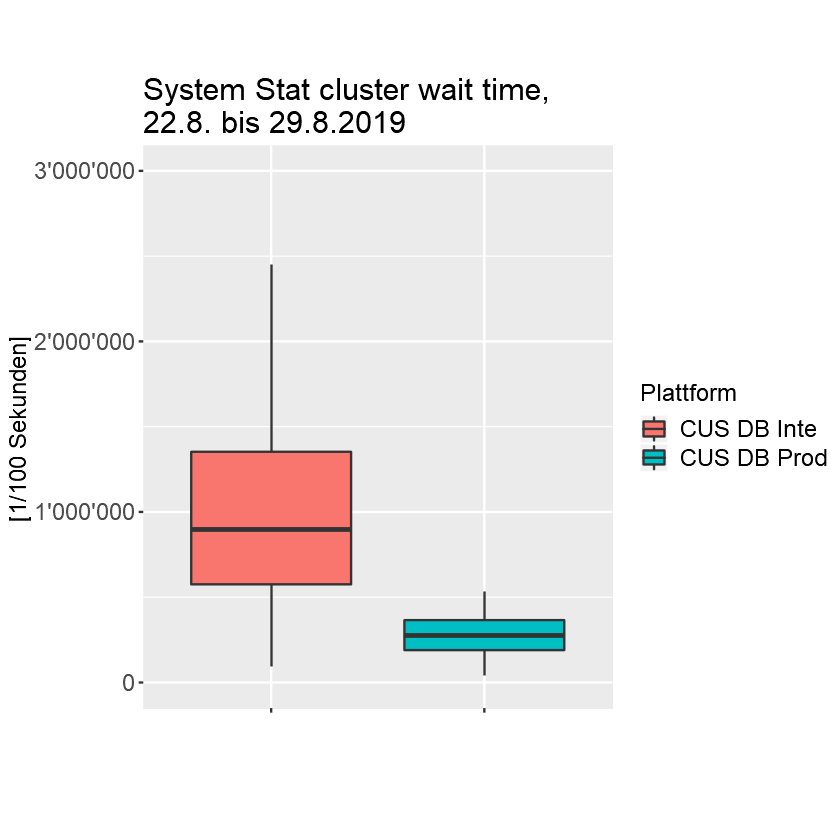

In [25]:
myTheme.screen = theme(
  aspect.ratio = 1.2,
  plot.title=element_text(size = 18),
  title = element_text(size = 14),
  axis.title.x = element_text(size = 14),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 14),
  axis.text.y = element_text(size = 14),
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 14)  
)

myTheme.plot = theme(
  plot.title=element_text(size = 28, face="bold"),
  title = element_text(size = 24),
  axis.title.x = element_text(size = 24),
  axis.text.x = element_text(size = 24),
  axis.title.y = element_text(size = 24),
  axis.text.y = element_text(size = 24),
  legend.title = element_text(size = 24, face="bold"),
  legend.text = element_text(size = 24)
)

p_clwt <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "cluster wait time" & !is.na(deltaValue), ])
p_clwt1 <- p_clwt + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable),  stat="boxplot", na.rm=TRUE, notch=FALSE)
p_clwt2 <- p_clwt1 +
    scale_y_continuous(limits = c(0,3e6), labels = scales::comma_format(big.mark="'"))
p_clwt3 <- p_clwt2 +
    labs(title="System Stat cluster wait time, \n22.8. bis 29.8.2019") +
    ylab("[1/100 Sekunden]")
p_clwt4 <- p_clwt3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_clwt4 + myTheme.screen

ggsave(plot=p_clwt4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.cluster_waiting_times.png")

### db block changes

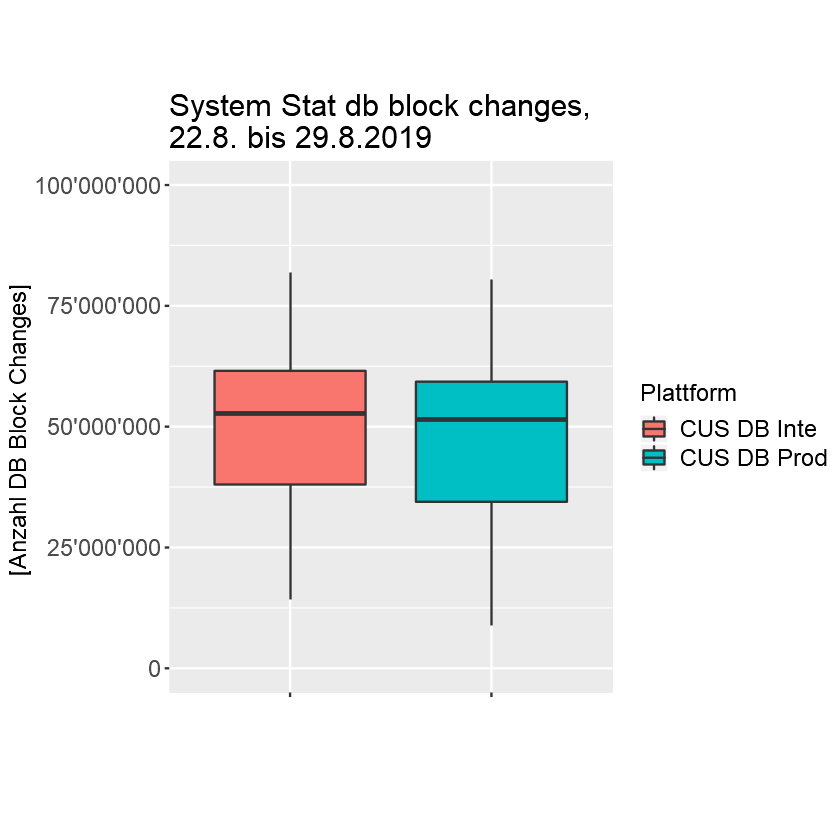

In [26]:
p_dbbcx <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "db block changes", ])
p_dbbcx1 <- p_dbbcx + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_dbbcx2 <- p_dbbcx1 +
    scale_y_continuous(limits = c(0,1e8), labels = scales::comma_format(big.mark="'"))
p_dbbcx3 <- p_dbbcx2 +
    labs(title="System Stat db block changes, \n22.8. bis 29.8.2019") +
    ylab("[Anzahl DB Block Changes]")
p_dbbcx4 <- p_dbbcx3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_dbbcx4 + myTheme.screen    

ggsave(plot=p_dbbcx4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.data_block_changes.png")

### execute count

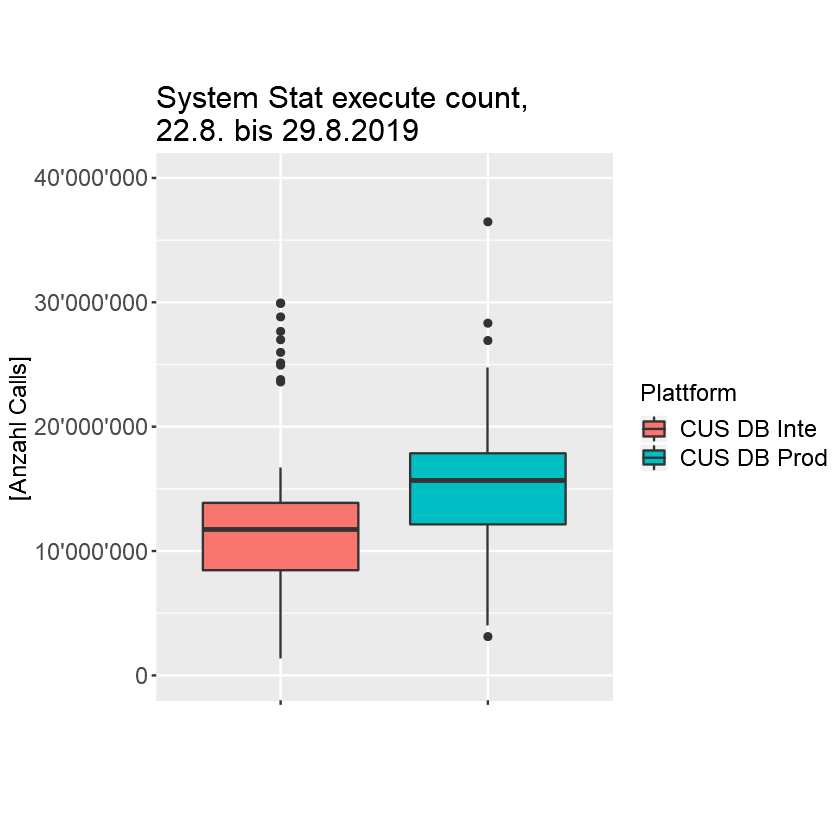

In [27]:
p_excnt <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "execute count", ])
p_excnt1 <- p_excnt + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_excnt2 <- p_excnt1 +
    scale_y_continuous(limits = c(0,4e7), labels = scales::comma_format(big.mark="'"))
p_excnt3 <- p_excnt2 +
    labs(title="System Stat execute count, \n22.8. bis 29.8.2019") +
    ylab("[Anzahl Calls]")
p_excnt4 <- p_excnt3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_excnt4 + myTheme.screen

ggsave(plot=p_excnt4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.execute_count.png")

### enqueue requests

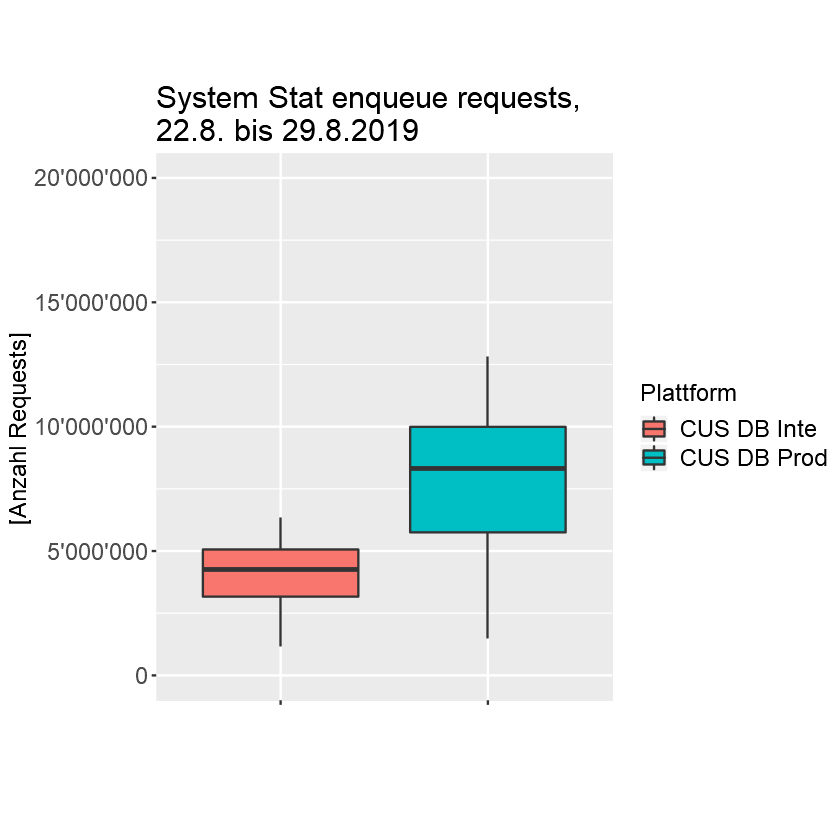

In [28]:
p_enqrq <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "enqueue requests", ])
p_enqrq1 <- p_enqrq + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_enqrq2 <- p_enqrq1 +
    scale_y_continuous(limits = c(0,2e7), labels = scales::comma_format(big.mark="'"))
p_enqrq3 <- p_enqrq2 +
    labs(title="System Stat enqueue requests, \n22.8. bis 29.8.2019") +
    ylab("[Anzahl Requests]")
p_enqrq4 <- p_enqrq3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_enqrq4 + myTheme.screen

ggsave(plot=p_enqrq4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.enqueue_request.png")

### global enqueue gets async + global enqueue gets sync

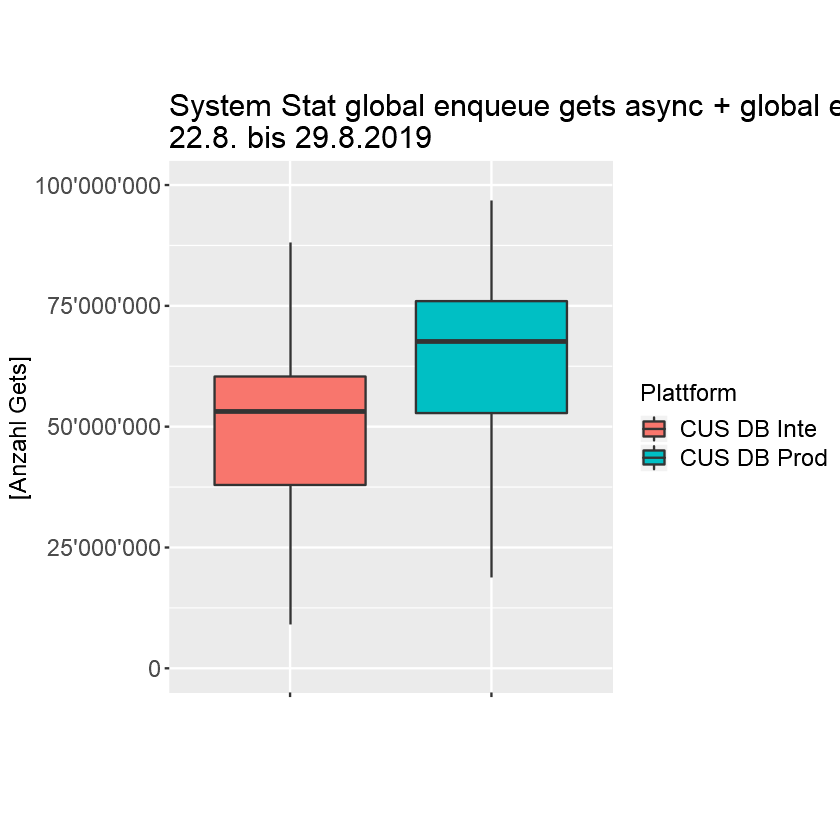

In [29]:
tmp.gegas <- dtNulled.selectForLoad.melt.diff[
  STAT_NAME %in% c("global enqueue gets async", "global enqueue gets sync"),
  list("sumValue" = sum(deltaValue)), by=list(snapHour, variable) ]

## global enqueue gets async + global enqueue gets sync
p_gegas <- ggplot(data=tmp.gegas)
p_gegas1 <- p_gegas + geom_boxplot(aes(x=variable, y=sumValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_gegas2 <- p_gegas1 +
    scale_y_continuous(limits = c(0,1e8), labels = scales::comma_format(big.mark="'"))
p_gegas3 <- p_gegas2 +
    labs(title="System Stat global enqueue gets async + global enqueue gets sync, \n22.8. bis 29.8.2019") +
    ylab("[Anzahl Gets]")
p_gegas4 <- p_gegas3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_gegas4 + myTheme.screen

ggsave(plot=p_gegas4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.glob_enq_gets_sync_async.png")

### parse count (total)

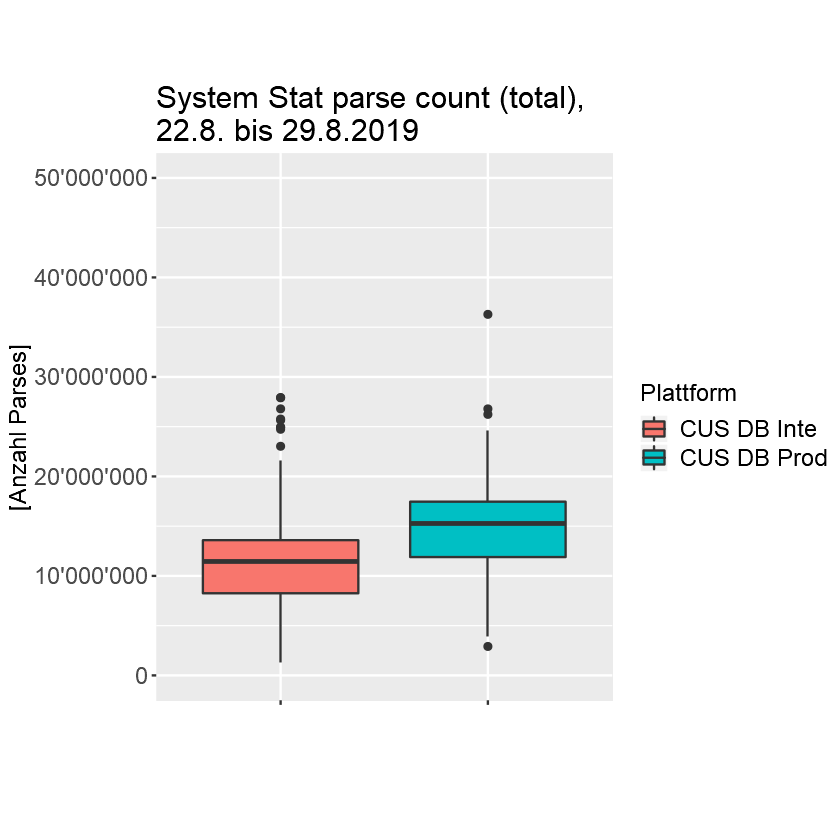

In [30]:
p_pcntt <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "parse count (total)", ])
p_pcntt1 <- p_pcntt + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_pcntt2 <- p_pcntt1 +
    scale_y_continuous(limits = c(0,5e7), labels = scales::comma_format(big.mark="'"))
p_pcntt3 <- p_pcntt2 +
    labs(title="System Stat parse count (total), \n22.8. bis 29.8.2019") +
    ylab("[Anzahl Parses]")
p_pcntt4 <- p_pcntt3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_pcntt4 + myTheme.screen

ggsave(plot=p_pcntt4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.parse_count_total.png")

### user calls

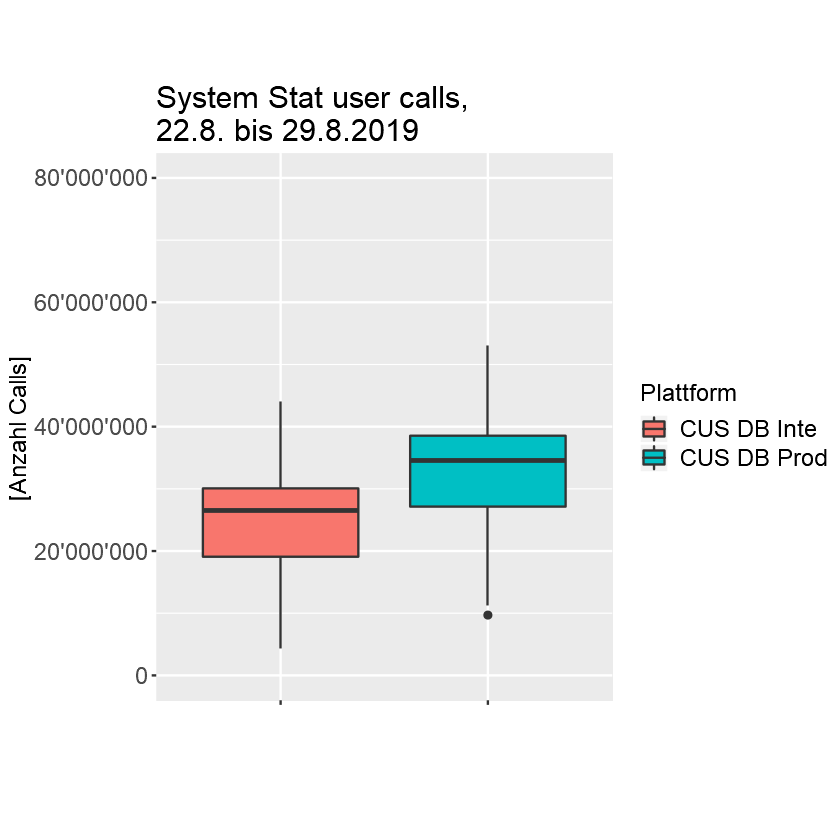

In [31]:
p_uc <- ggplot(data=dtNulled.selectForLoad.melt.diff[ STAT_NAME == "user calls", ])
p_uc1 <- p_uc + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE,notch=FALSE)
p_uc2 <- p_uc1 +
    scale_y_continuous(limits = c(0,8e7), labels = scales::comma_format(big.mark="'"))
p_uc3 <- p_uc2 +
    labs(title="System Stat user calls, \n22.8. bis 29.8.2019") +
    ylab("[Anzahl Calls]")
p_uc4 <- p_uc3 +
    scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_uc4 + myTheme.screen

ggsave(plot=p_uc4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.user_calls.png")

## Conclusions
* Cluster waiting times are much higher on the integration database than on the production database.
* There is no higher load on the integration database wrt. the production database, that could be taken into account to explain the difference.